### Import librairies

In [43]:
# imports des librairies nécessaires
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn import *
import sklearn
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
import numpy as np
import itertools
import warnings
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tools.eval_measures import rmse

### Lecture, traitement et visualisation des données

In [2]:
# lecture des données 
tractors_df = pd.read_csv("TractorSales.csv")

# traitement des données pour obtenir le bon format 
dates = pd.date_range(start = '2003-01-01',freq= 'MS',periods=len(tractors_df)) # générer les dates pour la période voulue
tractors_df['Month'] = dates.month
tractors_df['Month'] = tractors_df['Month'].apply(lambda x: calendar.month_abbr[x])
tractors_df['Year'] = dates.year
tractors_df.rename(columns={'Number of Tractor Sold':'Vente-Tracteurs'}, inplace=True)
tractors_df = tractors_df[['Month', 'Year', 'Vente-Tracteurs']]
tractors_df.set_index(dates, inplace=True)
tractors_df = tractors_df[['Vente-Tracteurs']]
tractors_df_copy = tractors_df.copy()
tractors_df.head(10)

,Vente-Tracteurs
2003-01-01,141
2003-02-01,157
2003-03-01,185
2003-04-01,199
2003-05-01,203
2003-06-01,189
2003-07-01,207
2003-08-01,207
2003-09-01,171
2003-10-01,150


#### Visualisation

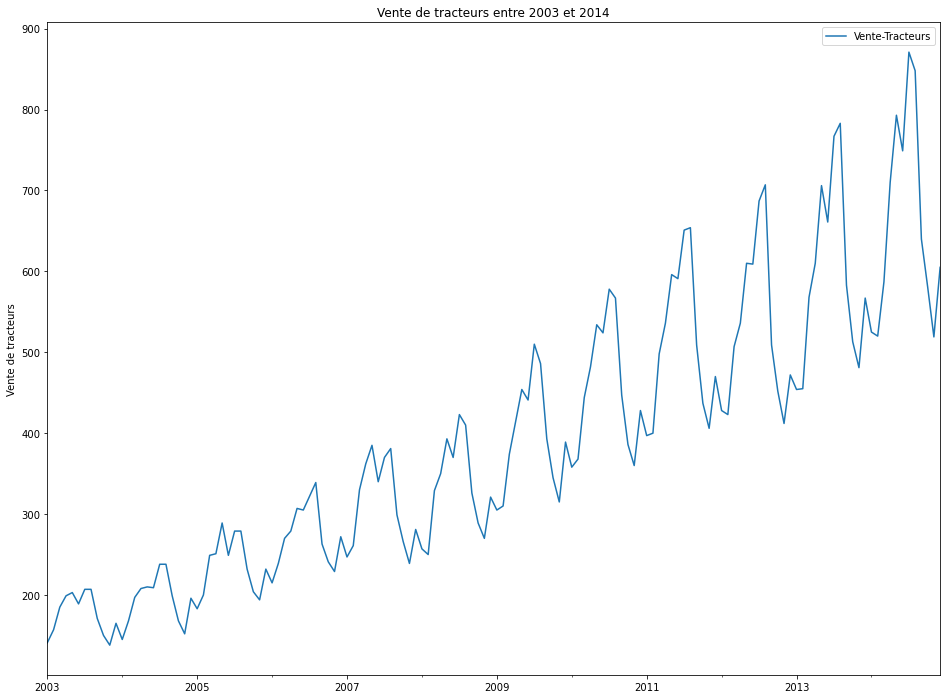

In [3]:
# visualisation des données
tractors_df.plot(figsize = (16,12))
plt.ylabel('Vente de tracteurs')
plt.title('Vente de tracteurs entre 2003 et 2014')
plt.show()

### Analyse descriptive
Maintenant que nous avons visualisé les données, nous pouvons commencer l'analyse.  
Série :   
-Additive :       y(t) = Level + Trend + Seasonality + Noise   
-Multiplicative : y(t) = Level * Trend * Seasonality * Noise
            

-> A partir du graphique, on peut déjà remarquer une forte tendance et une saisonalité + amplitude des pics qui augmente   
-> ici multiplicative car l'amplitude des pics augmente avec le temps 

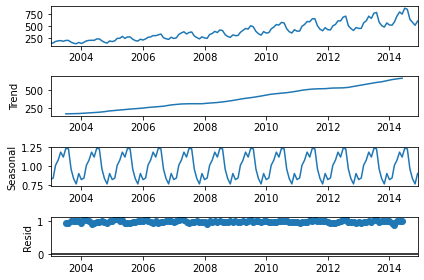

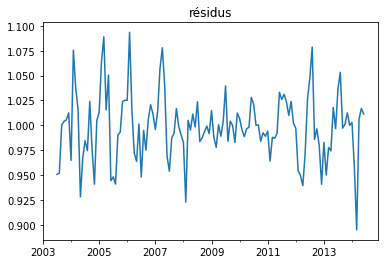

In [4]:
# décomposition des données pour visualiser la tendance, la saisonnalité et les résidus
decomp = sm.tsa.seasonal_decompose(tractors_df, model = 'multiplicative')
decomp.plot()
plt.savefig('decomp.jpg')
plt.show()

# on va plot les résidus séparément pour avoir une mise à l'échelle et mieux visualiser
residus = decomp.resid
residus.plot()
plt.title('résidus')
plt.show()

#### Test de stationnarité

In [5]:
# Test de stationnarité -> on sait que la série n'est pas stationnaire 
dftest = adfuller(tractors_df.values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  1.108825059146736
2. P-Value :  0.9952912415248419
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 129
5. Critical Values :
	 1% :  -3.482087964046026
	 5% :  -2.8842185101614626
	 10% :  -2.578864381347275


#### Transformation logarithmique

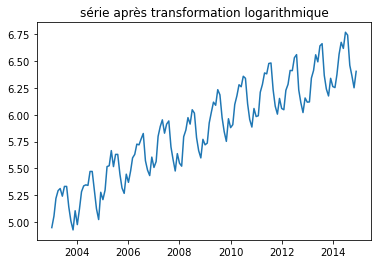

In [6]:
# Visuellement, on avait remarqué que la série n'était pas stationnaire et notre hypothèse a pu être confirmée avec le test de Dickey-Fuller
# On va commencer par appliquer une transformation logarithmique pour stationnariser les données (première étape) -> transforme le modèle de multiplicatif en additif
tractors_df_log = np.log(tractors_df)
tractors_df_log_copy = tractors_df_log.copy() # utile pour tester autoarima sans devoir remodifier le dataframe auquel on a ajouté la colonne avec les prédictions
plt.plot(tractors_df_log)
plt.title('série après transformation logarithmique')
plt.savefig('log.jpg')
plt.show()

#### Décomposition série log 

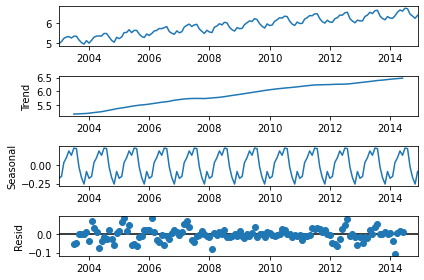

In [7]:
# Les données ont été stationnarisées -> plus d'augmentation d'amplitude
# On peut refaire une décomposition du modèle additif poir voir si on a bien stabilisé les données
result = seasonal_decompose(tractors_df_log, model = 'additive')
result.plot()
plt.show() 


#### Différentiation

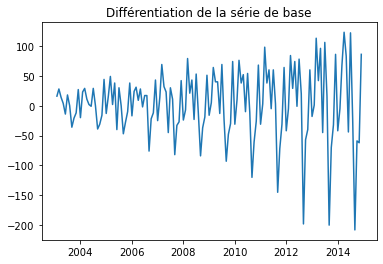

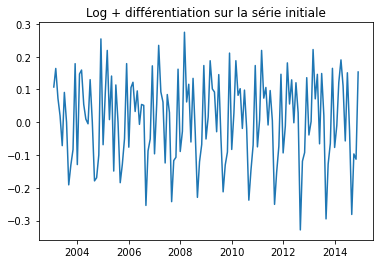

In [8]:
# Le modèle est devenu additif, mais on voit bien qu'il reste une tendance forte, l'objectif est de maintenant annuler la tendance pour stationnariser le modèle
# Pour passer de multiplicatif à additif, on a utilisé le log qui permet de stabiliser la variation d'amplitude, ici on veut annuler la tendance-> on différencie
d = tractors_df.diff()
plt.plot(d)
plt.title('Différentiation de la série de base')
plt.savefig('diffbase.jpg')
plt.show()
# on voit bien qu'il n'y a plus de tendance car on a différencié la série
# on peut faire la même chose sur le df log
dlogdiff = tractors_df_log.diff()
plt.plot(dlogdiff)
plt.title('Log + différentiation sur la série initiale')
plt.savefig('difflog.jpg')
plt.show()
# on voit bien que sur la série sur laquelle on a appliqué le log, il n'y a plus d'amplitude -> stationnaire
# (on peut vérifier la stationnarité avec une moyenne ou théoriquement avec le test de Dickey-Fuller)
# On a différentié la série donc plus de tendance

#### Visualisation

<AxesSubplot:title={'center':'Série de base'}>

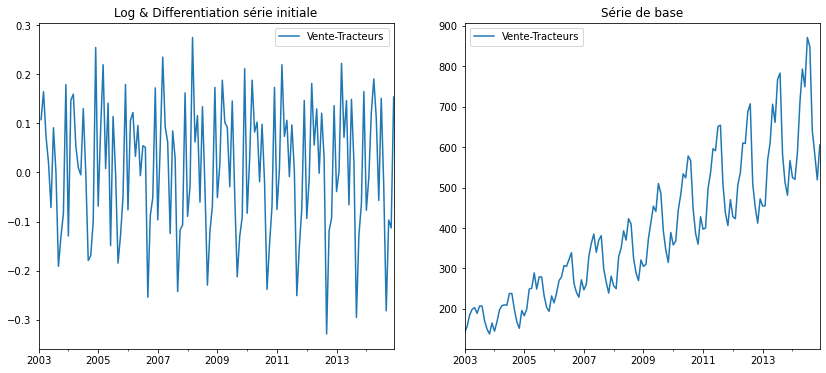

In [9]:
# comparaison série initiale et série qui a subi la transformation log et la différentiation
ax1 = plt.subplot(121)
dlogdiff.plot(figsize=(14,6), title="Log & Differentiation série initiale", ax=ax1)
ax2 = plt.subplot(122)
tractors_df.plot(figsize=(14,6), title="Série de base", ax=ax2)

In [10]:
# On peut refaire le test de stationnarité pour voir si ce qu'on a fait a bien fonctionné
dftest = adfuller(dlogdiff.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)
# p-value > 0.05 toujours non stationnaire

1. ADF :  -2.680467119996607
2. P-Value :  0.07747972836508323
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 128
5. Critical Values :
	 1% :  -3.4825006939887997
	 5% :  -2.884397984161377
	 10% :  -2.578960197753906


L'hypothèse de stationnarité ne peut toujours pas être acceptée.  
Nous pouvons remarquer une forte saisonnalité (12 mois) en analysant les graphiques.  
L'objectif est donc de retirer cette saisonnalité pour stationnariser la série.
Pour cela, nous allons effectuer une différentiation saisonnière sur la série qui a déjà été différenciée + log

#### Différentiation saisonnière

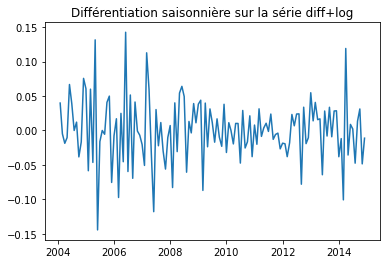

In [11]:
# différentiation saisonnière
d1  = pd.DataFrame(dlogdiff)
d12 = d1-d1.shift(12)
plt.title('Différentiation saisonnière sur la série diff+log')
plt.plot(d12)
plt.savefig('difflogsais.jpg')
plt.show()

#### Test de stationnarité

In [12]:
# On peut refaire le test de stationnarité pour voir si ce qu'on a fait a bien fonctionné
dftest = adfuller(d12.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)
# p-value < 0.05 toujours -> STATIONNAIRE

1. ADF :  -4.4809622221427
2. P-Value :  0.0002128161041120004
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 118
5. Critical Values :
	 1% :  -3.4870216863700767
	 5% :  -2.8863625166643136
	 10% :  -2.580009026141913


### ACF et PACF

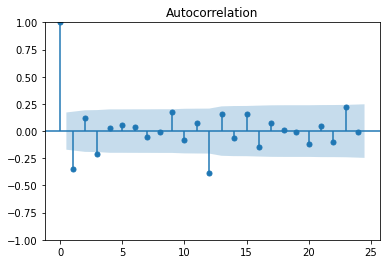

D:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


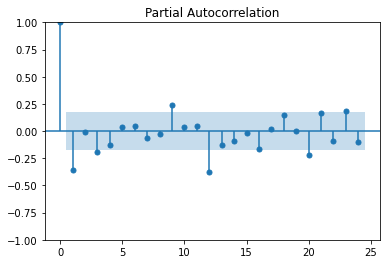

In [13]:
# calcul ACF et PACF qui vont nous servir pour identifier les paramètres du modèle SARIMA
plot_acf(d12.dropna(),lags=24) # drop les Nan vu qu'on a shifté tout 
plt.savefig('ACF.jpg')
plt.show()
plot_pacf(d12.dropna(),lags=24)
plt.savefig('PACF.jpg')
plt.show()
# les analyses de ACF/PACF sont expliquées dans le rapport

## MODELE SARIMA (p,d,q)(P,D,Q)m

D,d =  ordre de différentiation     
P,p = AR ordre, nombre de termes AR (P pour composante saisonnalité)    
Q,q = MA ordre pour composant saisonnalité, nombre de termes MA  (Q pour composante saisonnalité)  
m = période  

Pour déterminer les meilleurs paramètres pour le modèle, on peut utiliser 3 méthodes:
1) ACF PACF plots =  méthode 'intelligente' d'analyse des ACF et PACF
2) Grid search = méthode brute force -> tester toutes les possibilités 
3) AutoSarima = méthode automatique
   

Dans les prochaines parties, nous allons nous concentrer sur la méthode 1 car c'est celle demandée mais les deux autres méthodes ont été implémentées pour comparer les résultats obtenus ! 

### Analyse ACF PACF 
P Q = 1 -> saisonnalité à 12
p q = ? -> on voit aussi que ça ressort en 1, on pourrait commencer par 0 et puis améliorer  
d = 1 -> 1 différentiation    
D = 0 tendance dans la saisonnalité ici non -> 0  
m = 12   
Après l'analyse des acf et pacf, on peut donc conclure que les paramètres du meilleur modèle seraient :  

Meilleur Modèle = (0,1,1)(1,0,1)12 



On applique SARIMA sur la série additive (log)

#### Séparation des données entraînement et test

In [14]:
# Séparation du modèle en test et entrainement
train = tractors_df_log.iloc[:132]
test = tractors_df_log.iloc[132:]

#### Premier modèle

In [30]:
# On veut maintenant créer le modèle 
mod = sm.tsa.statespace.SARIMAX(train, order=(0,1,1), seasonal_order=(1,0,1,12))
results = mod.fit()
print (results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    Vente-Tracteurs   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 230.674
Date:                            Fri, 14 Jan 2022   AIC                           -453.348
Time:                                    22:03:15   BIC                           -441.847
Sample:                                01-01-2003   HQIC                          -448.675
                                     - 12-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3075      0.075     -4.122      0.000      -0.454      -0.161
ar.S.L12       0.9934      0.006   

#### Deuxième modèle

In [16]:
# deuxième modèle créé pour tester, on voit bien que ça ne sert à rien car paramètre proche de 0 donc inutile
# on veut éviter l'overfitting
mod2 = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,1,12))
results2 = mod2.fit()
print (results2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    Vente-Tracteurs   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 230.693
Date:                            Fri, 14 Jan 2022   AIC                           -451.386
Time:                                    22:02:28   BIC                           -437.010
Sample:                                01-01-2003   HQIC                          -445.544
                                     - 12-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3242      0.306     -1.061      0.289      -0.923       0.275
ma.L1          0.0359      0.336   

D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Etude des résidus du modèle

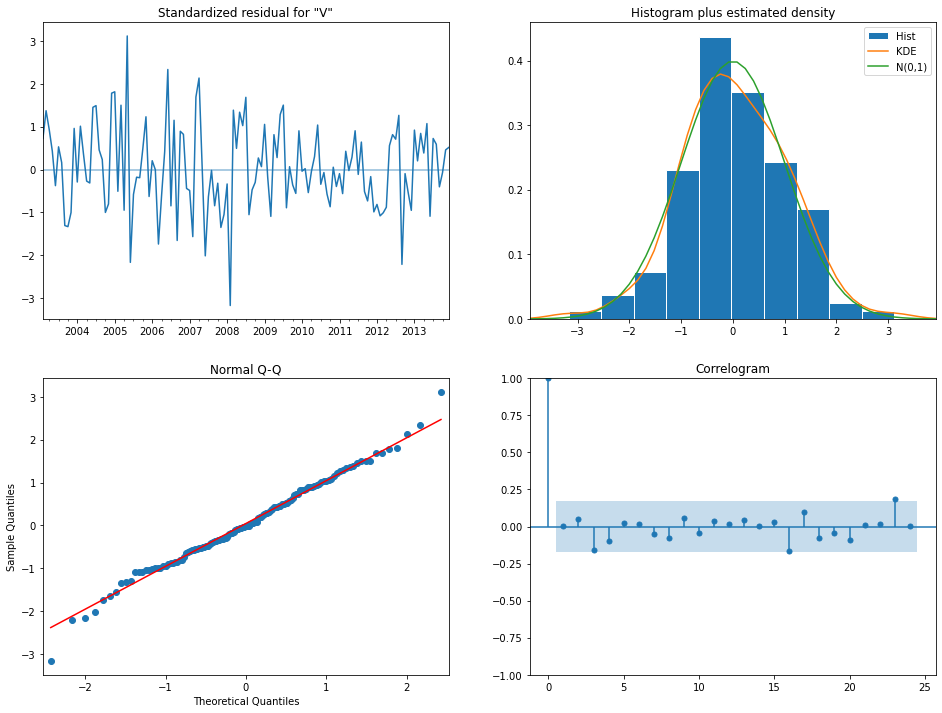

In [31]:
# plot des résidus du modèle
results.plot_diagnostics(lags = 24, figsize=(16, 12))
plt.show()

### Test de Ljung-Box
Corrélation entre les résidus ?

In [32]:
acorr_ljungbox(results.resid, lags=[24], return_df=True)
# -> les résidus sont indépendants car p-value > 0.05
# ici lags = 24 car 2*12 (saisonnalité), on s'est basé sur un article de blog pour fixer ce paramètre
# https://robjhyndman.com/hyndsight/ljung-box-test/ lien où on a trouvé 

,lb_stat,lb_pvalue
24,1.235152,1.0


### Test de Shapiro
Normalité des résidus ?

In [33]:
shapiro_test = shapiro(results.resid)
print(shapiro_test)

ShapiroResult(statistic=0.12738436460494995, pvalue=1.5169660114970038e-24)


## Prédictions

In [20]:
# log -> on rend le modèle additif, on entraine sur le modèle loggé et ensuite, on doit faire les prédictions sur la série initiale donc on doit prendre exp(prediction)
predictions = results.get_prediction(start= 132,end = len(tractors_df_log_copy)-1,dynamic=False)
# comme on a une série multiplicative qu'on a rendu additive avec un log en base 2, on sait que pour avoir la 
# vraie bonne prédiction, il ne faut pas juste faire exp() mais que la prévision optimale de la série initiale n’est pas exp[Xt(l)] mais : exp[Xt(l) + 1/2*var(et(l))]
# transformation log pas linéaire -> E[exp(y)] != exp(E[y]) -> E[exp(y)] >= exp(E[y])

# intervalle de confiance
predictions_IC = predictions.conf_int()
# vu qu'on fait les prédictions sur la série qui a subi une transformation logarithmique, il faut prendre l'exponentielle des prédictions pour avoir
# la valeur des prédictions sur la série de base mais pour avoir la solution optimale, il faut prendre en compte la variance de l'erreur de prévison lors 
# du passage à la série initiale (inverse log -> exponentielle)  
pred = np.exp(predictions.predicted_mean)


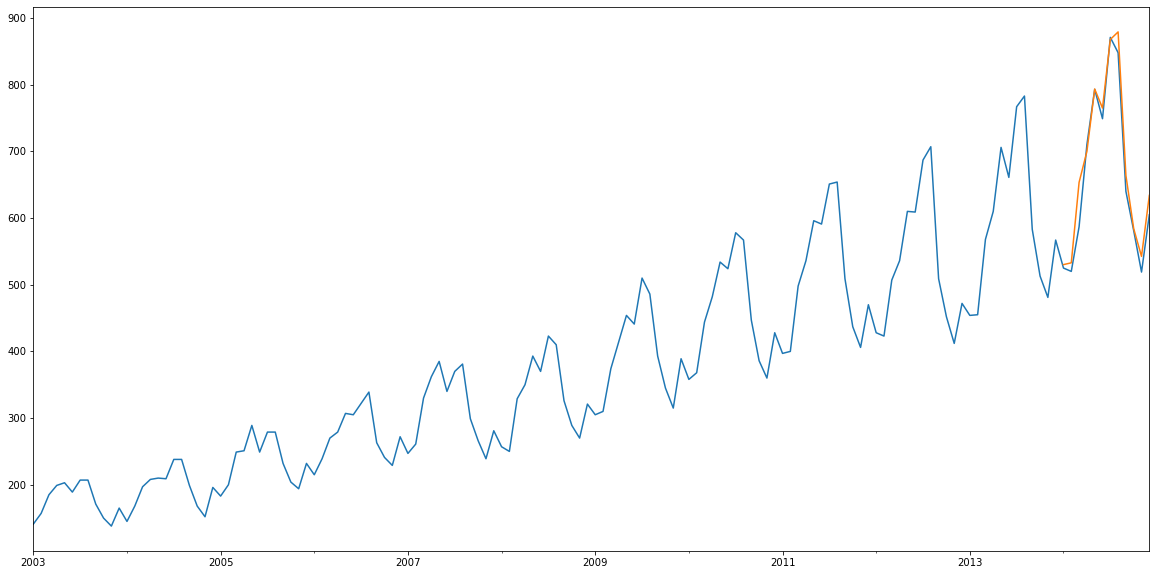

In [34]:
tractors_df["Vente-Tracteurs"].plot()
pred.plot(figsize = (20,10))
plt.savefig('predictions.jpg')
plt.show()

## Indicateurs sur les prédictions

In [55]:
# MSE prédiction sur modèle log 
y = predictions.predicted_mean
y_vrai = tractors_df_log_copy["Vente-Tracteurs"][132:len(tractors_df_log_copy)] 
mse = ((y - y_vrai) ** 2).mean()
print('MSE = {}'.format(round(mse, 5)))


MSE = 0.00164


In [56]:
# MSE sur les vraies données
y_vrai = tractors_df_copy["Vente-Tracteurs"][132:len(tractors_df_log_copy)] 
mse = ((pred - y_vrai) ** 2).mean()
print('MSE = {}'.format(round(mse, 5)))


MSE = 661.17045


In [57]:
# MAE (calculé sur les données initiales et exp(prédictions))
y_vrai = tractors_df_copy["Vente-Tracteurs"][132:] 
mae = sklearn.metrics.mean_absolute_error(y_vrai, pred)
print('MAE = {}'.format(round(mae, 5)))

MAE = 18.75257


#### Grid search pour trouver les meilleurs paramètres
Au lieu d'analyser ACF et PACF pour identifier les paramètres du modèle, on peut utiliser un grid search.  
Se base sur AIC pour calculer le score du modèle


In [25]:
# grid search pour trouver les meilleurs paramètres du modèle en fonction de AIC
# méthode trouvée dans la littérature en cherchant une technique de brute force pour trouver les meilleurs paramètres
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(train,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue
print("Meilleur SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Meilleur SARIMAX(1, 1, 0)x(1, 0, 1, 12)12 model - AIC:-453.3823648924838


#### Autoarima
Enfin, pour trouver les meilleurs paramètres, on peut utiliser autoarima, un package python.  
Se base sur AIC et BIC pour avoir le meilleur modèle


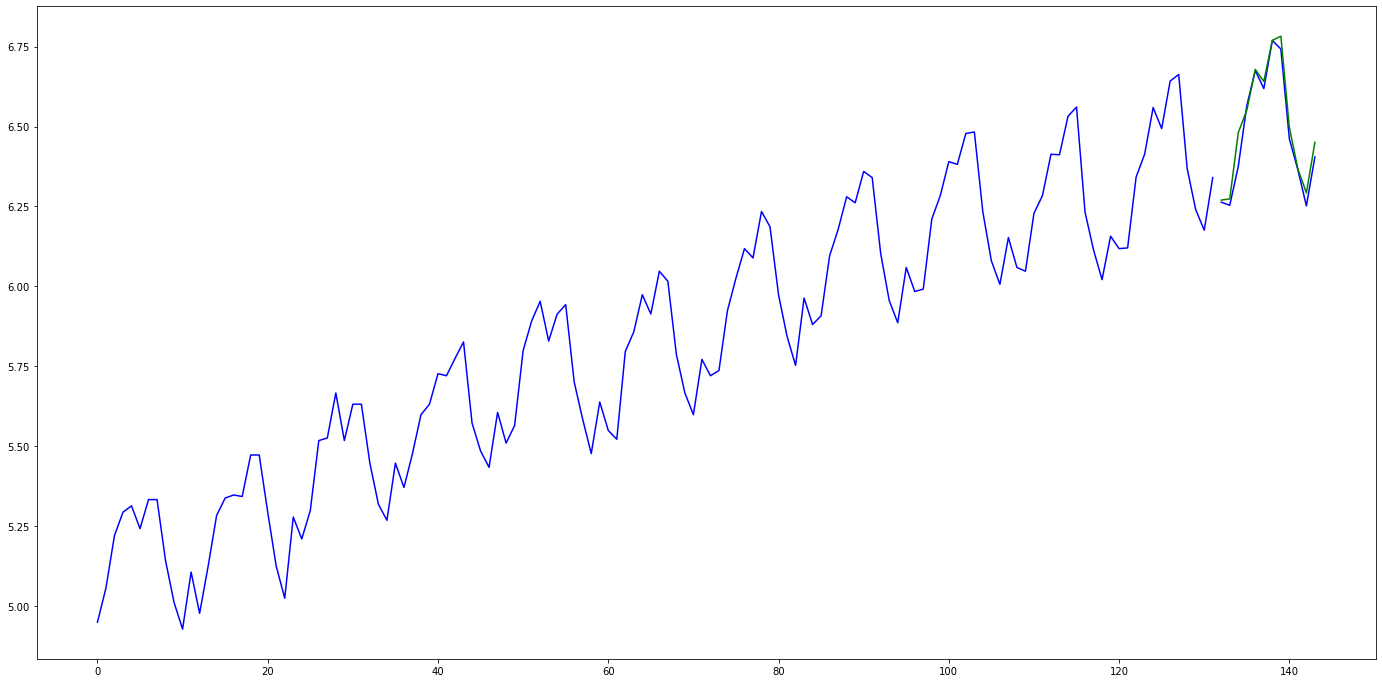

In [38]:
# Load les données
y = tractors_df_log_copy
train, test = train_test_split(y, train_size=132)

# Fit le modèle
model = pm.auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=False,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=500)

# Faire les prédictions
forecasts = model.predict(test.shape[0])  
# -> utilise un mixte entre AIC et BIC pour trouver le meilleur modèle
x = np.arange(y.shape[0])
plt.plot(x[:132], train, c='blue')
plt.plot(x[132:],test,c='blue')
plt.plot(x[132:], forecasts, c='green')
plt.rcParams["figure.figsize"] = (24,12)
plt.show()


In [39]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 223.935
Date:                            Fri, 14 Jan 2022   AIC                           -441.870
Time:                                    22:04:53   BIC                           -433.533
Sample:                                         0   HQIC                          -438.485
                                            - 132                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3531      0.080     -4.408      0.000      -0.510      -0.196
ma.S.L12      -0.5575      0.094     -5.925      0.000      -0.742      -0.373
sigma2         0.0013      0.000      8.612      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.45
Prob(Q):                              0.96   Prob(JB):                         0.48
Heteroskedasticity (H):               0.39   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
# MAE 
y_vrai = tractors_df_copy["Vente-Tracteurs"][132:] 
mae = sklearn.metrics.mean_absolute_error(y_vrai, np.exp(forecasts))
print('MAE = {}'.format(round(mae, 5)))
# MSE prédiction sur modèle log 
y = np.exp(forecasts)
mse = ((y - y_vrai) ** 2).mean()
print('MSE = {}'.format(round(mse, 5)))


MAE = 18.26664
MSE = 657.98571
